#### Данные взяты из открытого источника:

https://collegescorecard.ed.gov/data/

В данных содержится информация о доходах бывших студентов университетов США спустя 6-10 лет после окончания университета.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

%matplotlib inline

In [2]:
# Данные по заработной плате
df = pd.read_csv("pydata/Most-Recent-Cohorts-Treasury-Elements.csv")
df.dropna(how='all', axis=1, inplace=True)

# Избавимся от строковых данных, заменив PrivacySuppresed на NaN
_df = df.iloc[:, :].apply(lambda x: x == 'PrivacySuppressed', axis=1)
df[_df] = np.nan

# Документация к данным, в которой содержится расшифовровка переменных и тип переменной
explanation = pd.read_csv("pydata/CollegeScorecardDataDictionary.csv", sep=';', usecols=[0, 3, 4])
explanation.dropna(how='any', inplace=True)
explanation_dict = dict(zip(explanation.iloc[:, 2], explanation.iloc[:, 0]))

# Выберем колонки с данными, в которых хранятся числовые значения и приведем их к типу float
float_columns = explanation.loc[
    (explanation.iloc[:, 1] == 'float') | (explanation.iloc[:, 1] == 'integer'), 
    'VARIABLE NAME'
]

for column in float_columns:
    if column in df.columns:
        df[column] = df[column].astype('float64')


Для лучшего знакомства с данными посмотрим, что представляют собой переменные, хранящиеся в датафрейме.

In [3]:
for column in df.columns:
    print(column, '-', explanation_dict[column])

UNITID - Unit ID for institution
OPEID - 8-digit OPE ID for institution
OPEID6 - 6-digit OPE ID for institution
INSTNM - Institution name
AGEGE24 - Percent of students over 23 at entry
PCT_WHITE - Percent of the population from students' zip codes that is White, via Census data
PCT_BLACK - Percent of the population from students' zip codes that is Black, via Census data
PCT_ASIAN - Percent of the population from students' zip codes that is Asian, via Census data
PCT_HISPANIC - Percent of the population from students' zip codes that is Hispanic, via Census data
PCT_BA - Percent of the population from students' zip codes with a bachelor's degree over the age 25, via Census data
PCT_GRAD_PROF - Percent of the population from students' zip codes over 25 with a professional degree, via Census data
PCT_BORN_US - Percent of the population from students' zip codes that was born in the US, via Census data
MEDIAN_HH_INC - Median household income
POVERTY_RATE - Poverty rate, via Census data
UNEMP

Так как сравнительная информация по студентам имеется только в отношение их расы:
**PCT_WHITE, PCT_BLACK, PCT_ASIAN, PCT_HISPANIC**, то взглянем сколько в процентном отношении составляют студенты каждой расы в университетах. Для этого построим гистограмму с процентными долями по каждой из рас.

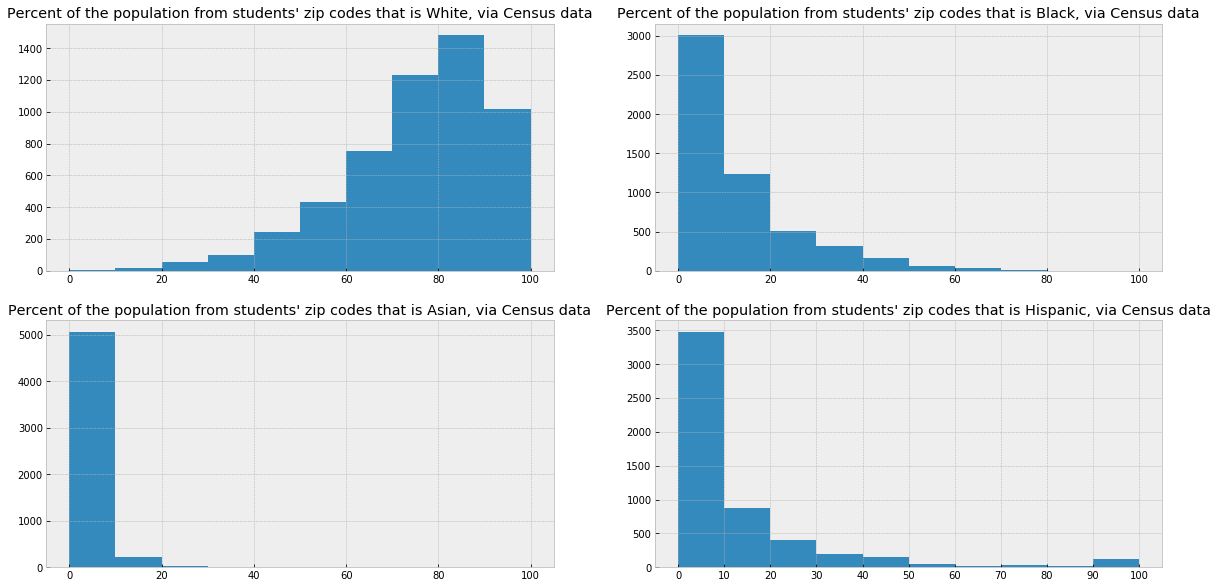

In [4]:
with plt.style.context(('bmh')):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    for i, column in enumerate(df.columns[5:9]):
        df_slice = df[column].dropna(how='any', axis=0)
        nums, ticks, var = axs[int(i > 1)][i % 2].hist(df_slice, bins=np.arange(0, 101, 10))
        _ = axs[int(i > 1)][i % 2].set_title(explanation_dict[column])
        _ = plt.xticks(ticks, np.round(ticks, 1))
        

Так в большинстве случаев более половины учащихся в университете представители европейской расы, то попытаемся взглянуть, каково различие между университетами, где белых учащихся меньше половины, и университетами где больше половины. Для это попытаемся ответить на вопросы, насколько успешнее реализуют себя учащиеся каждой из выделенным когорт.

In [5]:
# Создадим переменную, в которой будет хранится значение, больше или меньше половины учащихся в университете
# представители европейской расы

df["WHT_MR_50"] = df['PCT_WHITE'].apply(lambda x: True if x > 50 else False if x < 50 else np.nan)
explanation_dict.update({'WHT_MR_50': 'Has institution got more than 50% of students, whose are White'})

# Создадим отдельный датафрейм, в котором будут хранится только те университеты, где известен расовый состав
explain_df = df[df["WHT_MR_50"].apply(lambda x: not np.isnan(x))]

In [6]:
# Посмотрим на те условия, с которыми учащиеся приходят в университет

explain_df.loc[:, 
               ['MEDIAN_HH_INC', 
                'POVERTY_RATE', 
                'UNEMP_RATE', 
                'WHT_MR_50']]\
    .groupby('WHT_MR_50')\
    .mean()\
    .round(2)

,MEDIAN_HH_INC,POVERTY_RATE,UNEMP_RATE
WHT_MR_50,,,
False,52564.12,16.88,5.61
True,58311.40,10.24,3.69


Как можно увидеть, в университеты с порогом ниже 50% приходят люди из менее финансово успешных семей, в которых больше количество семей за чертой бедности и безработных.

In [7]:
# Для того, чтобы посмотреть, насколько равнозначно реализуют себя учащиеся, взглянем на доходы у студентов
# спустя 10 лет после выпуска из университета

explain_df.loc[:, 
               ['MN_EARN_WNE_P10',
                'MN_EARN_WNE_MALE0_P10', 
                'MN_EARN_WNE_MALE1_P10',
                'WHT_MR_50']
              ]\
    .groupby('WHT_MR_50')\
    .mean()\
    .round(2)

,MN_EARN_WNE_P10,MN_EARN_WNE_MALE0_P10,MN_EARN_WNE_MALE1_P10
WHT_MR_50,,,
False,31163.38,31279.27,37112.00
True,39045.36,36453.72,47618.63


Кажется, что различие между выпускниками двух когорт университетов различны. К тому же видны и различий в уровне зарплат между межчинами и женщинами. Для того, чтобы убедиться, что различие статистически значимо построим 99% доверительный интервал для когорты больше 50%.

In [8]:
def conf_intervals(data, conf=0.95):
    mean, sem, m = np.mean(data), st.sem(data), st.t.ppf((1 + conf) / 2., len(data) - 1)
    return mean - m * sem, mean + m * sem

print('Confidence interval: ', end='')
print(*map(lambda x: round(x, 2), 
           conf_intervals(explain_df['MN_EARN_WNE_P10'].dropna(how='any'), conf=.99)))

Confidence interval: 37721.33 39065.59


Таким образом можно отвергнуть нулевую гипотезу о равенстве среднего дохода спустя 10 лет посел выпуская университета на уровне значимости 1%.

Для наглядности взглянем на динамику изменения доли людей, чей доход превышает 25 000$ и на динамику роста средней заработной платы каждой из когорт за периоды спустя 6, 7..10 лет после выпуска из университета.

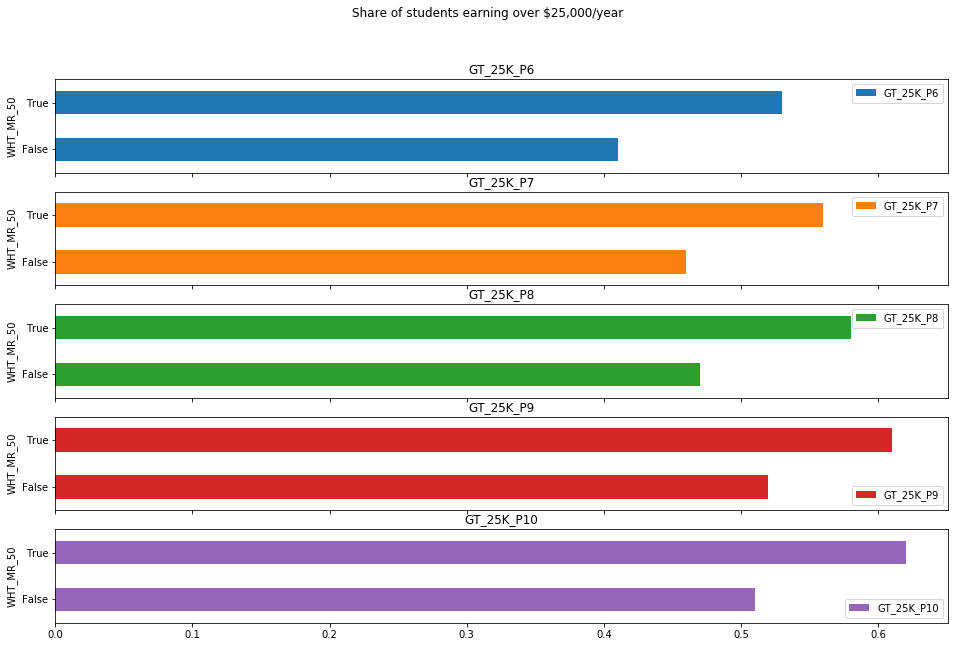

In [9]:
_ = explain_df.loc[:,
                   ['GT_25K_P6',
                    'GT_25K_P7',
                    'GT_25K_P8',
                    'GT_25K_P9',
                    'GT_25K_P10',
                    'WHT_MR_50']
                  ]\
        .groupby('WHT_MR_50')\
        .mean()\
        .round(2)\
        .plot(kind='barh', 
              figsize=(16, 10), 
              subplots=True, 
              title='Share of students earning over $25,000/year')

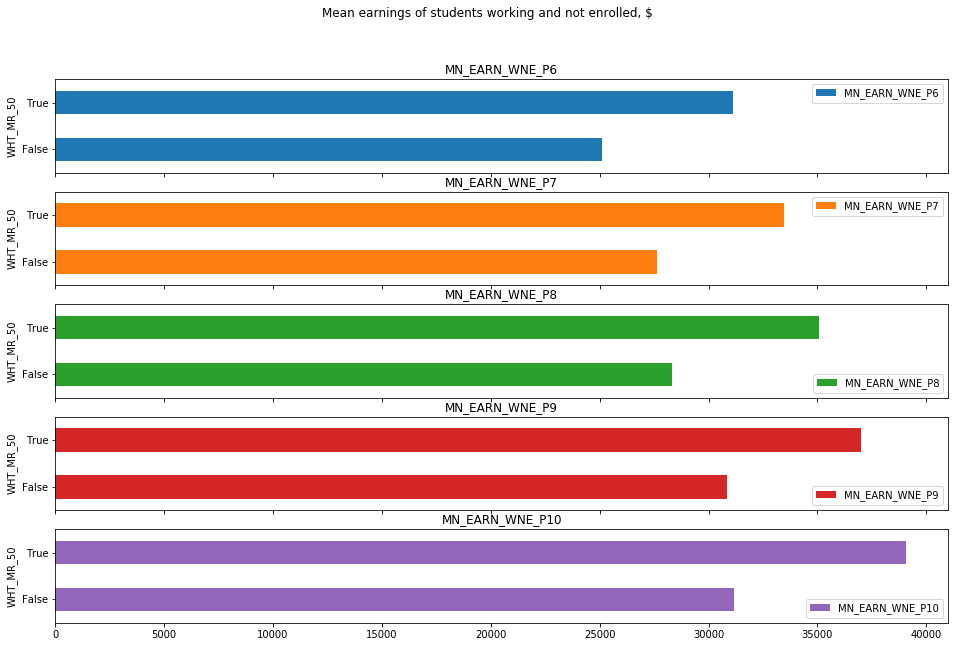

In [10]:
_ = explain_df.loc[:, 
                   ['MN_EARN_WNE_P6',
                    'MN_EARN_WNE_P7',
                    'MN_EARN_WNE_P8',
                    'MN_EARN_WNE_P9',
                    'MN_EARN_WNE_P10',
                    'WHT_MR_50']
                  ]\
        .groupby('WHT_MR_50')\
        .mean()\
        .round(2)\
        .plot(kind='barh', 
              figsize=(16, 10), 
              subplots=True, 
              title='Mean earnings of students working and not enrolled, $')

Исходя из полученных результатов хотелось бы взглянуть на статистику среднего дохода бывших выпускников в зависимости от процента белых учащихся, для того чтобы понять, имеется ли линейная зависимост между этими параметрами. Рассмотрим долю учащихся с шагом в 5% от **0 до 100%**.

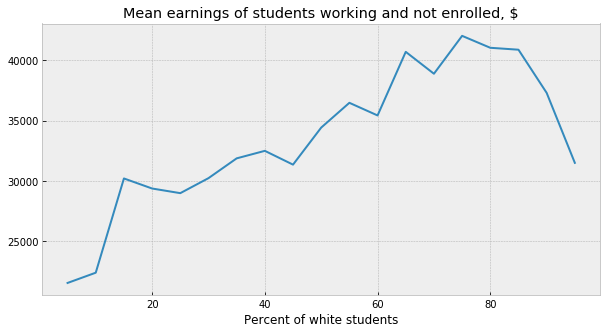

In [11]:
values_dict = {}

for perc in range(0, 101, 5):
    values_dict.update(
        {
            perc: explain_df['MN_EARN_WNE_P10'].loc[
                (explain_df['PCT_WHITE'] < perc + 5) & (explain_df['PCT_WHITE'] > perc)
            ].mean()
        })

with plt.style.context(('bmh')):
    plt.figure(figsize=(10, 5))
    plt.plot(list(values_dict.keys()), list(values_dict.values()))
    plt.title('Mean earnings of students working and not enrolled, $')
    plt.xlabel('Percent of white students')

Как можно увидеть, что зависимость имеет нелинейный характер. Более того, в университетах с подавляющим числом белых студентов доход учащихся спустя 10 лет ниже, чем в университетах со смешанным расовым составом.

В данных также хранится процентное соотношение студентов, родившихся в США. Посмотрим, каким образом этот фактор сказывается на будущих доходах учащихся.

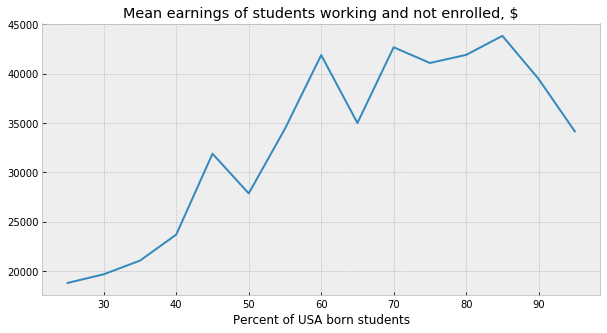

In [12]:
values_dict = {}

for perc in range(0, 101, 5):
    values_dict.update(
        {
            perc: explain_df['MN_EARN_WNE_P10'].loc[
                (explain_df['PCT_BORN_US'] < perc + 5) & (explain_df['PCT_BORN_US'] > perc)
            ].mean()
        })

with plt.style.context(('bmh')):
    plt.figure(figsize=(10, 5))
    plt.plot(list(values_dict.keys()), list(values_dict.values()))
    plt.title('Mean earnings of students working and not enrolled, $')
    plt.xlabel('Percent of USA born students')

Как мы видим, ситуация здесь почти не отличается от когорт с белым населением.

Последний вариант рассмотрения графика зависимости произведем с медианным доходом домашнего хозяйства, к которому принадлежит студент университета. Здесь шаг будет измеряться в 5000$.

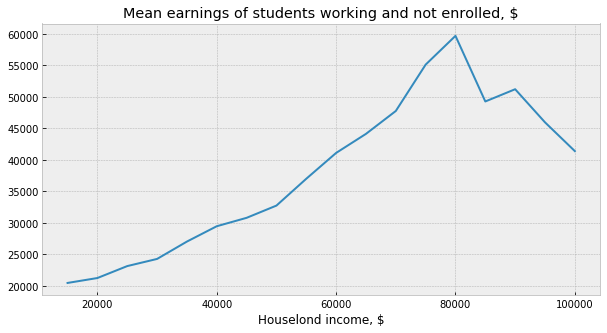

In [13]:
values_dict = {}

for perc in range(0, 105001, 5000):
    values_dict.update(
        {
            perc: explain_df['MN_EARN_WNE_P10'].loc[
                (explain_df['MEDIAN_HH_INC'] < perc + 5000) & (explain_df['MEDIAN_HH_INC'] > perc)
            ].mean()
        })

with plt.style.context(('bmh')):
    plt.figure(figsize=(10, 5))
    plt.plot(list(values_dict.keys()), list(values_dict.values()))
    plt.title('Mean earnings of students working and not enrolled, $')
    plt.xlabel('Houselond income, $')

Ситуация же с доходами домашнего хозяйства определяет будущий доход гораздо сильнее, как и на предыдущим графиках зависимость оказывается не линейно, но при этом пик оказывается значительно выше предыдущих значений. 

Остается проверить статистическую значимость данного отличия.

In [14]:
print('Confidence interval: ', end='')
print(*map(lambda x: round(x, 2), 
           conf_intervals(explain_df['MN_EARN_WNE_P10'].loc[
                (explain_df['MEDIAN_HH_INC'] < 80000 + 5000) & (explain_df['MEDIAN_HH_INC'] > 80000)
            ].dropna(how='any'), conf=.99)))

Confidence interval: 53982.59 65377.7


Таким образом, на уровне значимости 1% мы можем отвергнуть нулевую гипотезу о равенстве пиков графиков. Следовательно уровень дохода домашнего хозяства оказывает самое большое влияние на будущий доход студентов. 